In [1]:
from datetime import datetime
import sys

import importlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns

from utils import data_utils, data_loader, shape_utils

importlib.reload(data_utils)
importlib.reload(data_loader)
importlib.reload(shape_utils)

RUN_FOLDER = "../results/debug/"

In [2]:
kcm_inputs = data_utils.load_all_inputs(RUN_FOLDER, "kcm/")
atb_inputs = data_utils.load_all_inputs(RUN_FOLDER, "atb/")

(1394, 4, 128, 128)
1.6e-07


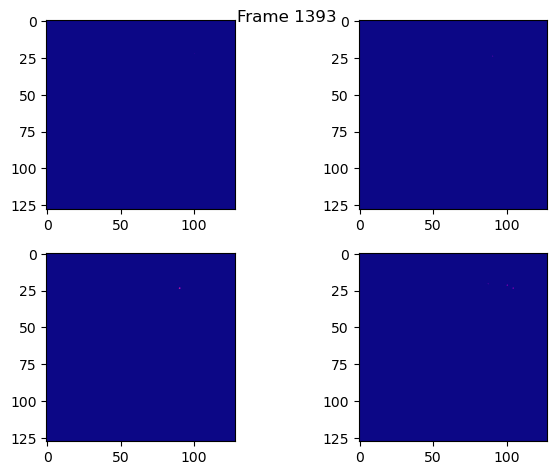

In [3]:
kcm_grid = kcm_inputs['train_grid']
print(kcm_grid.shape) # (tsteps, channels, latsteps, lonsteps)
print(sys.getsizeof(kcm_grid)*1e-9)
shape_utils.save_grid_anim(kcm_grid, "grid_speeds_kcm.mp4", 0, 35)

(77, 4, 128, 128)
1.6e-07


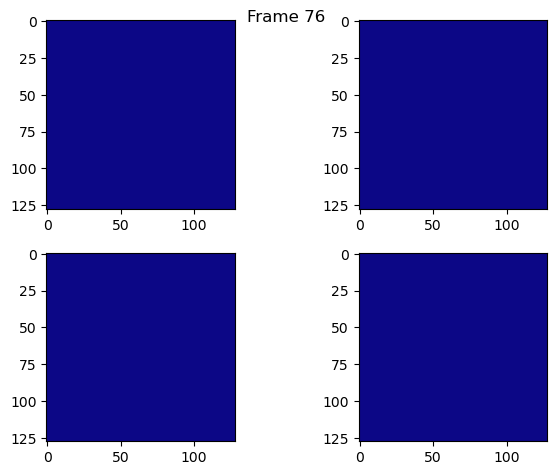

In [4]:
atb_grid = atb_inputs['train_grid']
print(atb_grid.shape) # (tsteps, channels, latsteps, lonsteps)
print(sys.getsizeof(atb_grid)*1e-9)
shape_utils.save_grid_anim(atb_grid, "grid_speeds_atb.mp4", 0, 35)

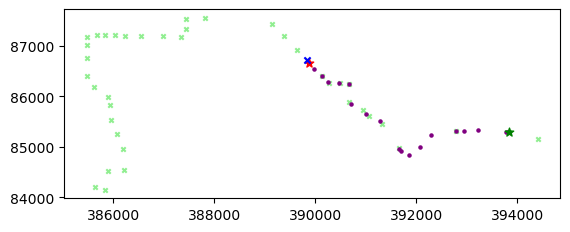

In [5]:
# Look at a single trip
test_traces = kcm_inputs['test_traces']
shingle_data = test_traces[test_traces['shingle_id']==5885]
# Plot overview of the shingle
plot_data = shingle_data
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], kcm_inputs['gtfs_data'], kcm_inputs['config']['epsg'])
shape_utils.plot_gtfsrt_trip(axes, plot_data, kcm_inputs['config']['epsg'])

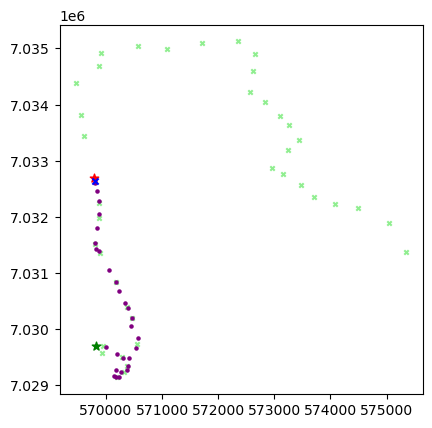

In [6]:
# Look at a single trip
test_traces = atb_inputs['test_traces']
shingle_data = test_traces[test_traces['shingle_id']==2]
shingle_data.head()
# Plot overview of the shingle
plot_data = shingle_data
fig, axes = plt.subplots(1,1)
shape_utils.plot_gtfs_trip(axes, plot_data['trip_id'].iloc[0], atb_inputs['gtfs_data'], atb_inputs['config']['epsg'])
shape_utils.plot_gtfsrt_trip(axes, plot_data, atb_inputs['config']['epsg'])

In [7]:
# Look at grid features for a shingle
importlib.reload(shape_utils)
grid = kcm_inputs['train_grid']
sample = kcm_inputs['train_data_chunks'][0][112]
tbins = sample['tbin_idx']
xbins = sample['xbin_idx']
ybins = sample['ybin_idx']
# Loop over each point in sample
grid_features = shape_utils.extract_grid_features(grid, tbins, xbins, ybins, n_prior=1, buffer=5)
print(np.min(grid_features))
print(np.max(grid_features))

-0.8336155341773924
1.5383217668473044


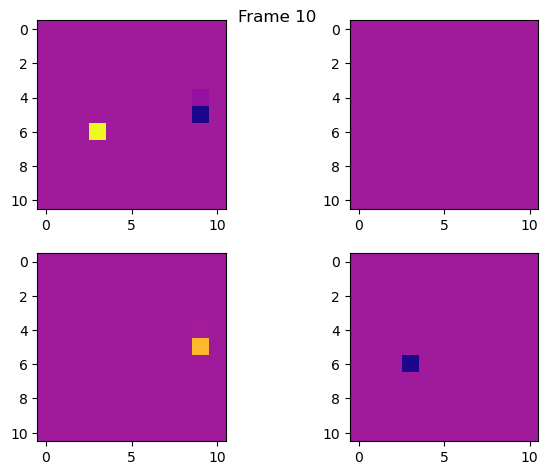

In [8]:
shape_utils.save_grid_anim(grid_features, "grid_speeds_shingle.mp4", np.min(grid_features), np.max(grid_features))

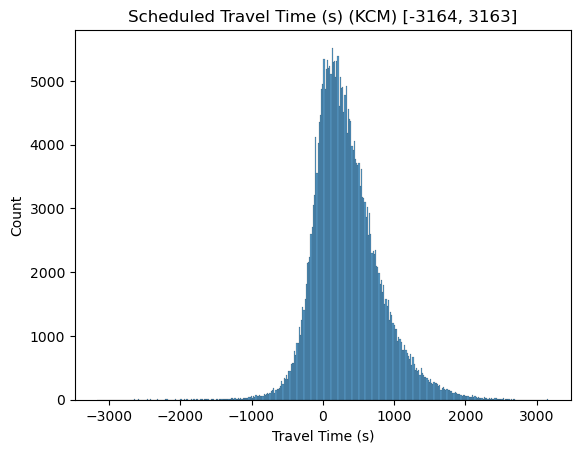

In [9]:
# Histogram of scheduled travel times
plot_data = kcm_inputs['train_traces']
sns.histplot(plot_data.scheduled_time_s)
plt.title(f"Scheduled Travel Time (s) (KCM) [{np.min(plot_data['scheduled_time_s'])}, {np.max(plot_data['scheduled_time_s'])}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/kcm_scheduled_time_dist.png")

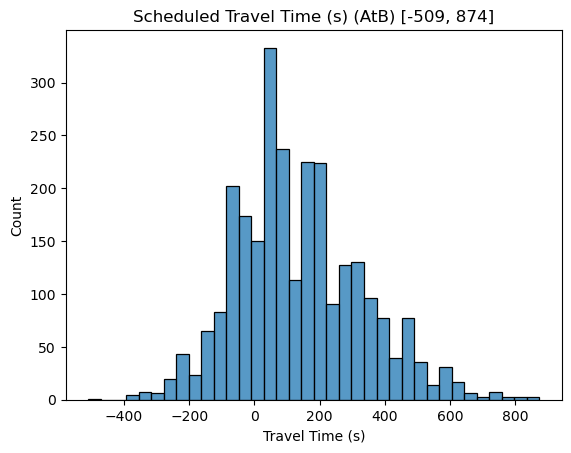

In [10]:
# Histogram of scheduled travel times
plot_data = atb_inputs['train_traces']
sns.histplot(plot_data.scheduled_time_s)
plt.title(f"Scheduled Travel Time (s) (AtB) [{np.min(plot_data['scheduled_time_s'])}, {np.max(plot_data['scheduled_time_s'])}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/atb_scheduled_time_dist.png")

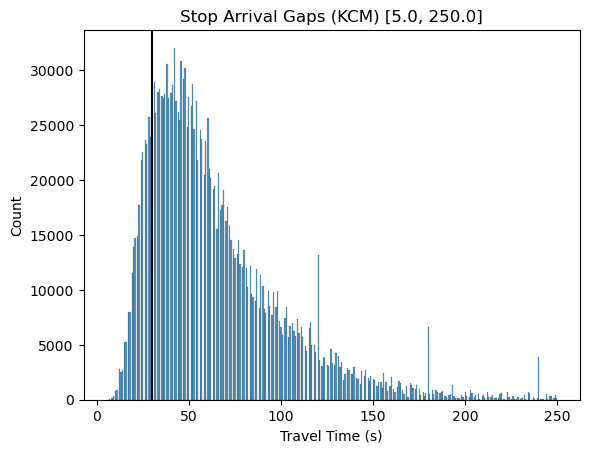

In [11]:
# Histogram of bus travel times in schedule
gtfs_data = kcm_inputs['gtfs_data']
x = gtfs_data[['trip_id','arrival_s']]
y = gtfs_data[['trip_id','arrival_s']].shift()
y.columns = [colname+"_shift" for colname in y.columns]
z = pd.concat([x,y], axis=1)
z = z[z['trip_id']==z['trip_id_shift']]
z['tt'] = z['arrival_s'] - z['arrival_s_shift']
z = z[z['tt']<=250]
z = z.dropna()
sns.histplot(z.tt)
plt.title(f"Stop Arrival Gaps (KCM) [{np.min(z['tt'])}, {np.max(z['tt'])}]")
plt.xlabel("Travel Time (s)")
plt.axvline(30, 0.0, 20000, color="black")
plt.savefig("../plots/kcm_gtfs_arrival_gaps.png")

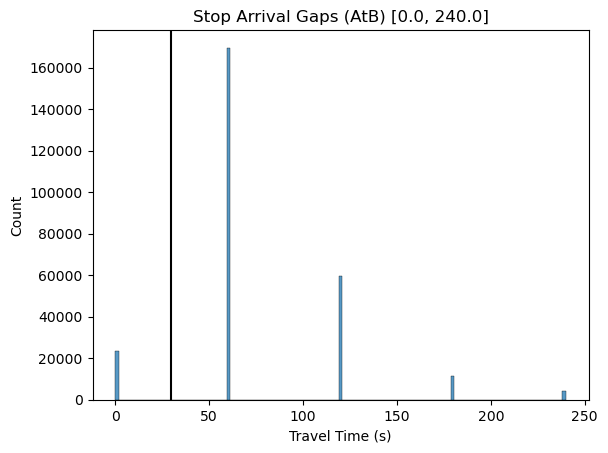

In [12]:
# Histogram of bus travel times in schedule
gtfs_data = atb_inputs['gtfs_data']

x = gtfs_data[['trip_id','arrival_s']]
y = gtfs_data[['trip_id','arrival_s']].shift()
y.columns = [colname+"_shift" for colname in y.columns]
z = pd.concat([x,y], axis=1)
z = z[z['trip_id']==z['trip_id_shift']]
z['tt'] = z['arrival_s'] - z['arrival_s_shift']
z = z[z['tt']<=250]
z = z.dropna()
sns.histplot(z.tt)
plt.title(f"Stop Arrival Gaps (AtB) [{np.min(z['tt'])}, {np.max(z['tt'])}]")
plt.xlabel("Travel Time (s)")
plt.axvline(30, 0.0, 20000, color="black")
plt.savefig("../plots/atb_gtfs_arrival_gaps.png")

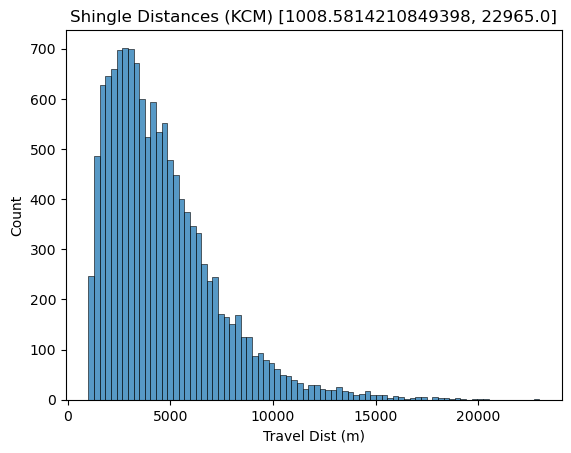

In [13]:
# Shingle distance
metric = kcm_inputs['train_traces'].groupby('shingle_id').sum(numeric_only=True)['dist_calc_m']
sns.histplot(metric)
plt.title(f"Shingle Distances (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Dist (m)")
plt.savefig("../plots/kcm_shingle_dists.png")

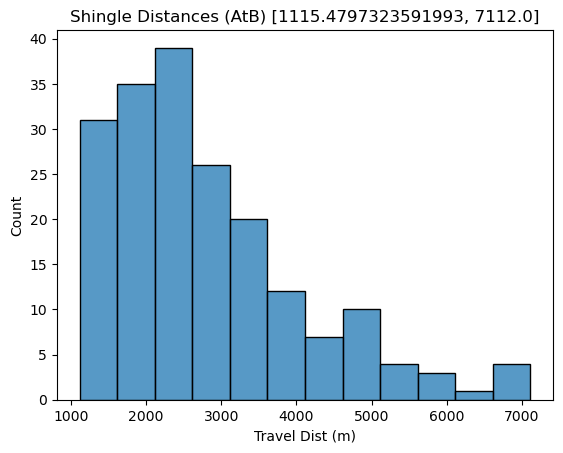

In [14]:
# Shingle distance
metric = atb_inputs['train_traces'].groupby('shingle_id').sum(numeric_only=True)['dist_calc_m']
sns.histplot(metric)
plt.title(f"Shingle Distances (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Dist (m)")
plt.savefig("../plots/atb_shingle_dists.png")

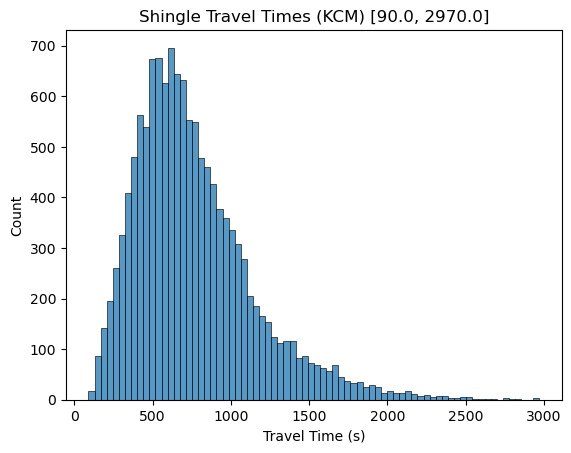

In [15]:
# Shingle travel time
metric = kcm_inputs['train_traces'].groupby('shingle_id').last()['time_cumulative_s']
sns.histplot(metric)
plt.title(f"Shingle Travel Times (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/kcm_shingle_times.png")

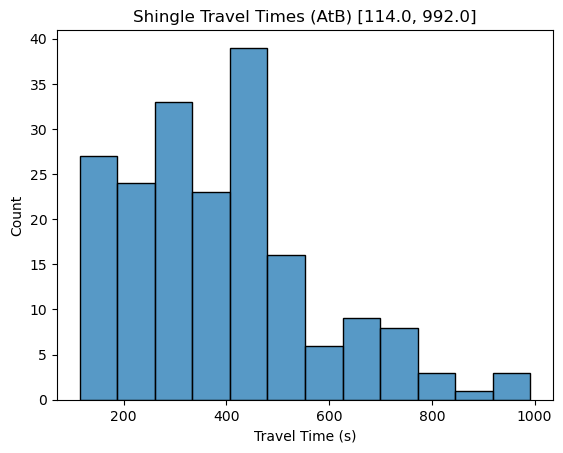

In [16]:
# Shingle travel time
metric = atb_inputs['train_traces'].groupby('shingle_id').last()['time_cumulative_s']
sns.histplot(metric)
plt.title(f"Shingle Travel Times (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Travel Time (s)")
plt.savefig("../plots/atb_shingle_times.png")

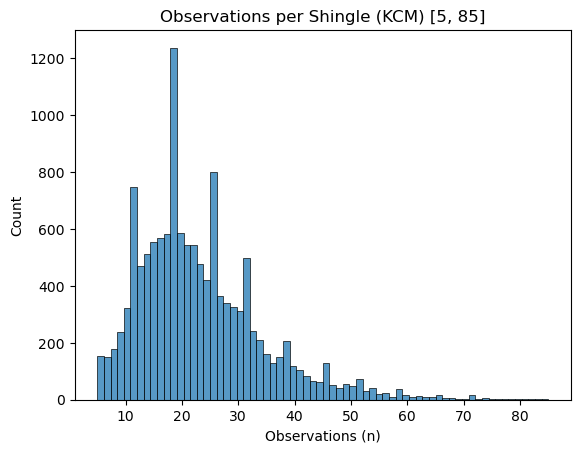

In [17]:
# Points per trajectory
metric = kcm_inputs['train_traces'].groupby(['shingle_id']).count()['lat']
sns.histplot(metric)
plt.title(f"Observations per Shingle (KCM) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Observations (n)")
plt.savefig("../plots/kcm_shingle_n.png")

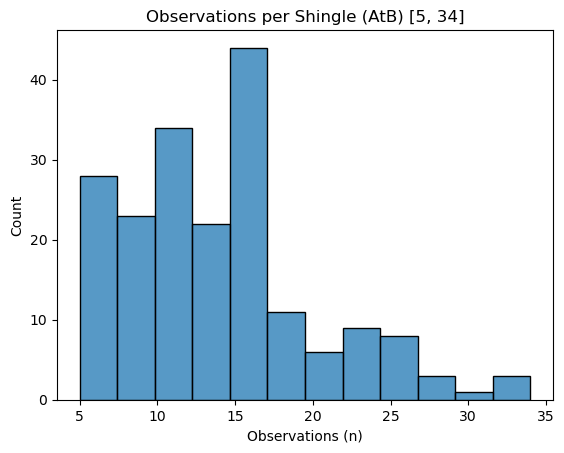

In [18]:
# Points per trajectory
metric = atb_inputs['train_traces'].groupby(['shingle_id']).count()['lat']
sns.histplot(metric)
plt.title(f"Observations per Shingle (AtB) [{np.min(metric)}, {np.round(np.max(metric))}]")
plt.xlabel("Observations (n)")
plt.savefig("../plots/atb_shingle_n.png")